In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaModel, AdamW
from transformers import RobertaTokenizer
import torch.optim as optim
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import numpy as np
import os

2023-10-11 06:01:49.714001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class BertAtt(nn.Module):
    def __init__(self, d_e, h):
        super(BertAtt, self).__init__()
        self.num_heads = h
        self.d_e = d_e
        self.head_dim = d_e // h
        
        self.q = nn.Linear(d_e, d_e)
        self.k = nn.Linear(d_e, d_e)
        self.v = nn.Linear(d_e, d_e)
        
        self.o = nn.Linear(d_e, d_e)
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)
        
        Q = Q.view(Q.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        attention_scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.d_e**0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, V)
        
        context = context.permute(0, 2, 1, 3).contiguous()
        context = context.view(context.size(0), -1, self.num_heads*self.head_dim)
        context = self.dropout(context)
        context = self.o(context)
        
        return self.layer_norm(x + context)

class HBN(nn.Module):
    def __init__(self, d_e, h, m, n, y, dropout_prob=0.01, max_sentences=114):
        super(HBN, self).__init__()
        
        # Token-level Roberta encoder
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        
        # Freeze Roberta weights
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        # Sentence-level BERT Encoder
        self.bertatt = BertAtt(d_e, h)
        
        self.ff = nn.Sequential(
            nn.Linear(d_e, n*d_e),
            nn.ReLU(),
            nn.Linear(n*d_e, d_e)
        )
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.multiple_bert_layers = nn.ModuleList([BertAtt(d_e, h) for _ in range(m)])
        
        self.transformation = nn.Linear(d_e, d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        # Prediction Layer
        self.predict = nn.Linear(d_e, y)
        
    def forward(self, input_ids, attention_mask):
#         print(input_ids.shape)
        # Token-level Roberta encoding
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]  # [batch_size, seq_length, hidden_size]
        
        # Average pooling to get sentence embeddings
        D = torch.mean(roberta_outputs, dim=1)  # [batch_size, hidden_size]
        
        out = self.bertatt(D)
        out = self.layer_norm(out + F.relu(self.ff(out)))
        
        Z = out
        for layer in self.multiple_bert_layers:
            Z = layer(Z)
        
        S = torch.tanh(torch.mean(Z, dim=1).mm(self.transformation.weight))
        S = self.dropout(S)
        scores = S.mm(self.predict.weight.t())
        
        return scores


In [3]:
# Parameters
d_e = 768  # Assuming you are using 'roberta-base'
h = 1     # Number of attention heads
m = 4      # Number of identical BERT layers
n = 4      # Scaling factor for feed-forward network
y = 2      # Number of classes, set this to your actual number
dropout_prob = 0.01 #dropout probability
num_train_samples = 50
num_epochs = 50

In [4]:
import os
import pandas as pd
from nltk.tokenize import sent_tokenize

folder1_path = 'sample-text/sample-text/politics/'
folder2_path = 'sample-text/sample-text/business/'

# Fetch file names from both folders
folder1_files = [f for f in os.listdir(folder1_path) if f.endswith('.txt')]
folder2_files = [f for f in os.listdir(folder2_path) if f.endswith('.txt')]

combined_data = []
num_sent=[]

# Read and label files from folder1 and count sentences
for file in folder1_files:
    with open(os.path.join(folder1_path, file), 'r') as f:
        content = f.read()
        num_sentences = len(sent_tokenize(content))
        combined_data.append((content, 0))
        num_sent.append(num_sentences)

# Read and label files from folder2 and count sentences
for file in folder2_files:
    with open(os.path.join(folder2_path, file), 'r') as f:
        content = f.read()
        num_sentences = len(sent_tokenize(content))
        combined_data.append((content, 1))
        num_sent.append(num_sentences)

# Convert combined_data to DataFrame
df = pd.DataFrame(combined_data, columns=['content', 'label'])

# Shuffle the DataFrame
data = df.sample(frac=1).reset_index(drop=True)

# Display the shuffled DataFrame
print(data)

# Find out the maximum number of sentences across all files
max_sentences = max(num_sent)
print(f"\nMaximum number of sentences across all files: {max_sentences}")


                                               content  label
0    Survey confirms property slowdown\n\nGovernmen...      1
1    Tories opposing 24-hour drinking\n\nThe Tories...      0
2    McConnell details Scots wave toll\n\nAt least ...      0
3    Saudi ministry to employ women\n\nWomen will b...      1
4    India power shares jump on debut\n\nShares in ...      1
..                                                 ...    ...
593  US adds more jobs than expected\n\nThe US econ...      1
594  School sport 'is back', says PM\n\nTony Blair ...      0
595  Fannie Mae 'should restate books'\n\nUS mortga...      1
596  Sport betting rules in spotlight\n\nA group of...      0
597  Howard denies split over ID cards\n\nMichael H...      0

[598 rows x 2 columns]

Maximum number of sentences across all files: 248


In [5]:
# len(test_indices),len(train_indices),len(val_indices)

In [6]:
# len(reviews_sentences)

In [7]:
# 2. Split data into train, validation, and test samples
num_train_samples = num_train_samples
num_val_samples = int(0.2 * num_train_samples)
train_data = data.iloc[:num_train_samples]
val_data = data.iloc[num_train_samples:num_train_samples+num_val_samples]
test_data = data.iloc[num_train_samples+num_val_samples:]

# 3. Preprocess and Flatten
def preprocess_and_flatten(dataframe):
    reviews = dataframe['content'].tolist()
    labels = dataframe['label'].tolist()
    reviews = [review.lower() for review in reviews]
    reviews_sentences = [sent_tokenize(review) for review in reviews]
    flattened_reviews = [sentence for review in reviews_sentences for sentence in review]
    flattened_labels = [label for review, label in zip(reviews_sentences, labels) for sentence in review]
    return flattened_reviews, flattened_labels

train_reviews, train_labels = preprocess_and_flatten(train_data)
val_reviews, val_labels = preprocess_and_flatten(val_data)
test_reviews, test_labels = preprocess_and_flatten(test_data)

# 4. Tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_tokens = tokenizer(train_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_sentences)
val_tokens = tokenizer(val_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_sentences)
test_tokens = tokenizer(test_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_sentences)

# 5. Create DataLoader
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(train_labels))
val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(val_labels))
test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=val_batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

# # Uncomment to test: iterating over the DataLoader
# for batch in train_loader:
#     input_ids, attention_mask, labels = batch
#     print(input_ids.shape, attention_mask.shape, labels.shape)
len(train_loader.dataset),len(val_loader.dataset),len(test_loader.dataset)

(967, 187, 9614)

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = HBN(d_e, h, m, n, y, dropout_prob).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def train(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            
            # For AUC
            # Assuming binary classification; you need to get the probabilities for the positive class
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(dataloader), accuracy, auc



In [10]:
# Actual Training Loop
train_loss_epoch = []
test_loss_epoch = []
auc = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    print(f"Train Loss: {train_loss:.4f}")
    val_loss, val_accuracy, val_auc = evaluate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")
    train_loss_epoch.append(train_loss)
    test_loss_epoch.append(val_loss)
    auc.append(val_auc)

Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:41<00:00,  5.81it/s]


Train Loss: 0.6490


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.4804, Val Accuracy: 0.7861, Val AUC: 0.8495


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.51it/s]


Train Loss: 0.4190


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.5311, Val Accuracy: 0.7112, Val AUC: 0.8846


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.3206


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.4171, Val Accuracy: 0.8182, Val AUC: 0.8994


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.2878


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.4285, Val Accuracy: 0.8342, Val AUC: 0.9023


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:36<00:00,  6.54it/s]


Train Loss: 0.2532


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.3964, Val Accuracy: 0.8342, Val AUC: 0.9045


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.52it/s]


Train Loss: 0.2469


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.5249, Val Accuracy: 0.7647, Val AUC: 0.9016


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.2201


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.9975, Val Accuracy: 0.6631, Val AUC: 0.8982


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.43it/s]


Train Loss: 0.2192


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.5212, Val Accuracy: 0.7914, Val AUC: 0.9013


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.49it/s]


Train Loss: 0.1940


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.74it/s]


Val Loss: 0.4572, Val Accuracy: 0.8235, Val AUC: 0.8973


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.51it/s]


Train Loss: 0.2088


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.82it/s]


Val Loss: 0.4622, Val Accuracy: 0.7968, Val AUC: 0.9059


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.33it/s]


Train Loss: 0.2133


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.61it/s]


Val Loss: 0.4067, Val Accuracy: 0.8235, Val AUC: 0.9007


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.37it/s]


Train Loss: 0.2002


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.66it/s]


Val Loss: 0.5279, Val Accuracy: 0.8128, Val AUC: 0.9007


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.31it/s]


Train Loss: 0.1756


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.58it/s]


Val Loss: 0.4412, Val Accuracy: 0.8128, Val AUC: 0.8897


Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.1747


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.75it/s]


Val Loss: 0.5341, Val Accuracy: 0.8021, Val AUC: 0.8828


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.44it/s]


Train Loss: 0.1666


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.6501, Val Accuracy: 0.7861, Val AUC: 0.8924


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.39it/s]


Train Loss: 0.1561


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.75it/s]


Val Loss: 0.6508, Val Accuracy: 0.7807, Val AUC: 0.8818


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.34it/s]


Train Loss: 0.1765


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.76it/s]


Val Loss: 0.4626, Val Accuracy: 0.8075, Val AUC: 0.8836


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.34it/s]


Train Loss: 0.1361


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.72it/s]


Val Loss: 0.6676, Val Accuracy: 0.7807, Val AUC: 0.8836


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.1428


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.6833, Val Accuracy: 0.7647, Val AUC: 0.8862


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.43it/s]


Train Loss: 0.1618


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.73it/s]


Val Loss: 0.6700, Val Accuracy: 0.7647, Val AUC: 0.8654


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.1625


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.5069, Val Accuracy: 0.7968, Val AUC: 0.8718


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.49it/s]


Train Loss: 0.1506


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.76it/s]


Val Loss: 0.6967, Val Accuracy: 0.7540, Val AUC: 0.8797


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.1372


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.6831, Val Accuracy: 0.7754, Val AUC: 0.8728


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.43it/s]


Train Loss: 0.1368


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.8222, Val Accuracy: 0.7166, Val AUC: 0.8779


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.51it/s]


Train Loss: 0.1669


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.5356, Val Accuracy: 0.7807, Val AUC: 0.8875


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.1257


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.6753, Val Accuracy: 0.7807, Val AUC: 0.8775


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.1409


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.76it/s]


Val Loss: 0.5834, Val Accuracy: 0.7861, Val AUC: 0.8613


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.49it/s]


Train Loss: 0.1307


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.5700, Val Accuracy: 0.7968, Val AUC: 0.8645


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.1341


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.65it/s]


Val Loss: 0.8030, Val Accuracy: 0.7754, Val AUC: 0.8712


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.34it/s]


Train Loss: 0.1197


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 0.5701, Val Accuracy: 0.8235, Val AUC: 0.8736


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.49it/s]


Train Loss: 0.1335


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.68it/s]


Val Loss: 0.6508, Val Accuracy: 0.7701, Val AUC: 0.8796


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.48it/s]


Train Loss: 0.1198


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 0.7147, Val Accuracy: 0.7754, Val AUC: 0.8817


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.35it/s]


Train Loss: 0.1256


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.76it/s]


Val Loss: 0.7873, Val Accuracy: 0.7380, Val AUC: 0.8676


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.21it/s]


Train Loss: 0.1393


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.66it/s]


Val Loss: 0.6016, Val Accuracy: 0.7861, Val AUC: 0.8657


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.39it/s]


Train Loss: 0.1428


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.81it/s]


Val Loss: 0.6292, Val Accuracy: 0.7487, Val AUC: 0.8658


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.43it/s]


Train Loss: 0.1058


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 0.6518, Val Accuracy: 0.7380, Val AUC: 0.8785


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.51it/s]


Train Loss: 0.1137


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 0.6094, Val Accuracy: 0.7914, Val AUC: 0.8694


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.0932


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.9268, Val Accuracy: 0.7380, Val AUC: 0.8601


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.1058


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 1.1133, Val Accuracy: 0.6578, Val AUC: 0.8600


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.1220


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.4746, Val Accuracy: 0.8075, Val AUC: 0.8725


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.1040


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.7674, Val Accuracy: 0.8021, Val AUC: 0.8851


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.39it/s]


Train Loss: 0.1214


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.5276, Val Accuracy: 0.7754, Val AUC: 0.8562


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.31it/s]


Train Loss: 0.1160


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 1.1208, Val Accuracy: 0.6631, Val AUC: 0.8546


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.1053


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.73it/s]


Val Loss: 0.7332, Val Accuracy: 0.7754, Val AUC: 0.8763


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.38it/s]


Train Loss: 0.0807


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.75it/s]


Val Loss: 0.8049, Val Accuracy: 0.7968, Val AUC: 0.8565


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.37it/s]


Train Loss: 0.1203


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.9681, Val Accuracy: 0.7059, Val AUC: 0.8498


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.0986


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.74it/s]


Val Loss: 0.6880, Val Accuracy: 0.7968, Val AUC: 0.8623


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.1099


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.6529, Val Accuracy: 0.7914, Val AUC: 0.8606


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.41it/s]


Train Loss: 0.1100


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.73it/s]


Val Loss: 0.7239, Val Accuracy: 0.7647, Val AUC: 0.8706


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.1050


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.75it/s]

Val Loss: 0.7306, Val Accuracy: 0.7754, Val AUC: 0.8662


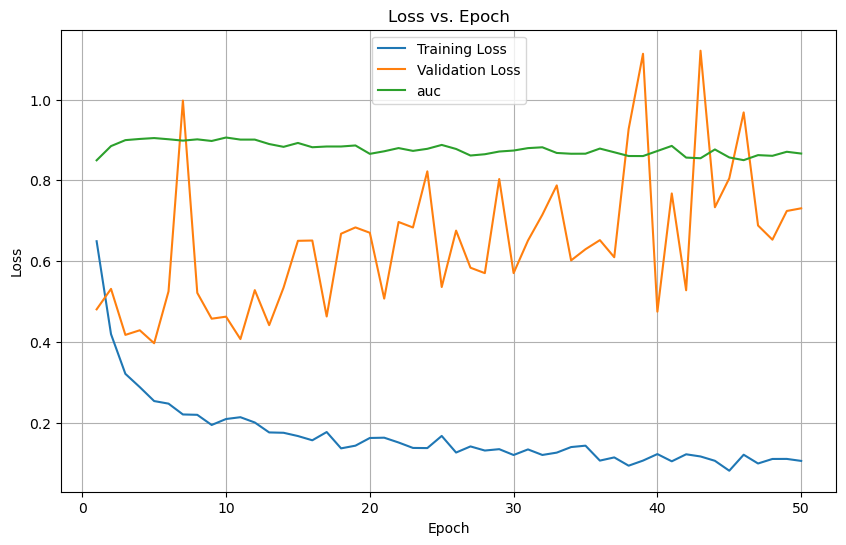

In [11]:
import matplotlib.pyplot as plt

# Plot Loss vs. Epoch
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_epoch, label='Training Loss')
plt.plot(epochs, test_loss_epoch, label='Validation Loss')
plt.plot(epochs, auc, label='auc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
val_loss, val_accuracy, val_auc = evaluate(model, test_loader, criterion, device)
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 2404/2404 [06:41<00:00,  5.98it/s]

Val Loss: 0.4719, Val Accuracy: 0.8644, Val AUC: 0.9362


In [13]:
len(test_loader.dataset)

9614